1. From the below mlops diagram
  * We opt for TF-IDF.
  * We use Bi-grams (Take two words at a time)
  * We use 1000 max features (take 1000 most common words)

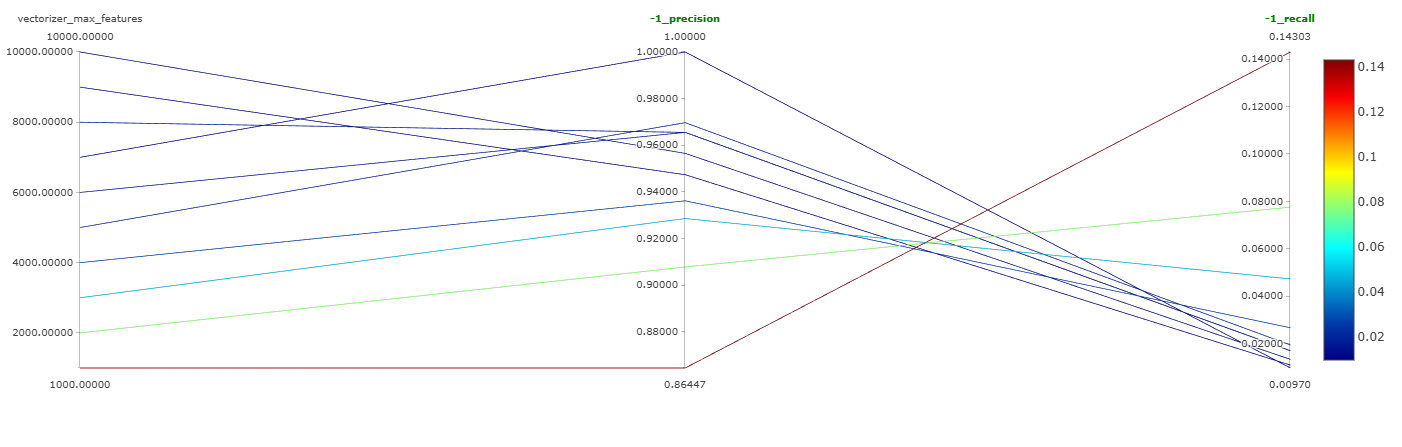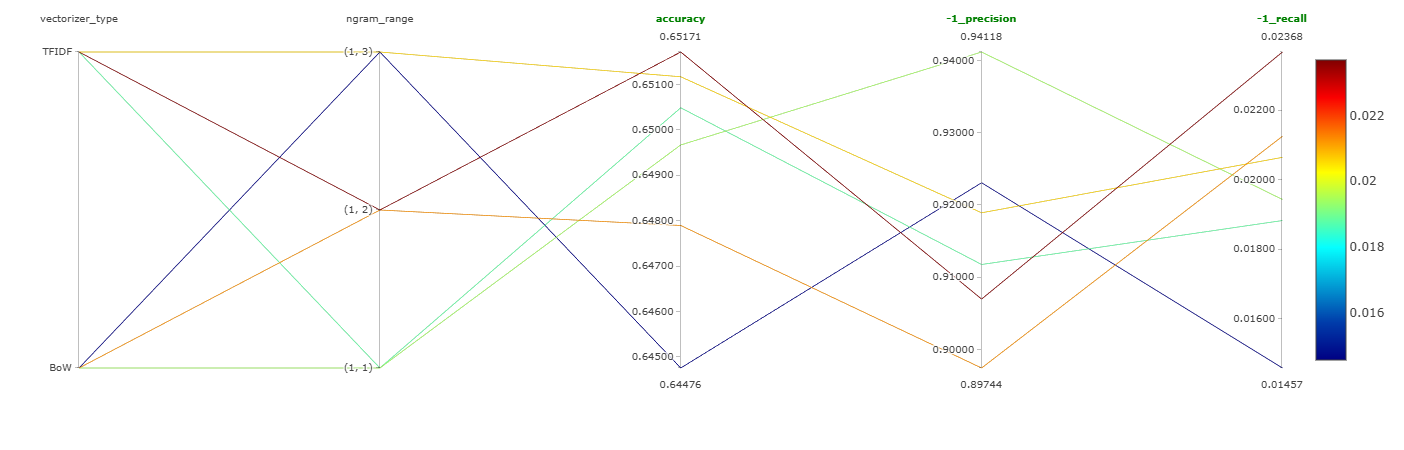

In [1]:
!pip install mlflow boto3 awscli

In [ ]:
!aws configure

In [3]:
import mlflow
mlflow.set_tracking_uri('http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/')
mlflow.set_experiment('Experiment-4 Hndling Imbalanced Dataset')

2025/07/26 13:26:39 INFO mlflow.tracking.fluent: Experiment with name 'Experiment-4 Hndling Imbalanced Dataset' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-26072025/981416064461852476', creation_time=1753536399512, experiment_id='981416064461852476', last_update_time=1753536399512, lifecycle_stage='active', name='Experiment-4 Hndling Imbalanced Dataset', tags={}>


Story: The Class Participation Problem in a Classroom
Imagine you're a teacher in a class with:

👨‍🎓 90 "Majority" students (Class 0: Very talkative)

👩‍🎓 10 "Minority" students (Class 1: Very shy)

You’re conducting a debate (i.e., training a classifier) and want fair representation.
But naturally, the majority class dominates.
You try different strategies to balance the participation.



| Method               | Story Analogy                            | What It Does                          |
| -------------------- | ---------------------------------------- | ------------------------------------- |
| `class_weight`       | Make shy kids’ words count more          | Adjusts importance (no data change)   |
| `SMOTE`              | Clone shy kids with slightly new views   | Adds synthetic minority samples       |
| `ADASYN`             | Clone the **most ignored** shy kids      | Smart oversampling near trouble areas |
| `RandomUnderSampler` | Remove some loud kids to level the class | Shrinks the majority class            |
| `SMOTEENN`           | Clone shy kids + remove troublemakers    | Over- and under-sampling + denoising  |


In [4]:
import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
df=pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [7]:
def run_imbalanced_experiment(imbalanced_methods):
  ngram_range=(1,2)
  vectorized_max_features=1000

  X_train,X_test,y_train,y_test=train_test_split(df['clean_comment'],df['category'],test_size=0.2,random_state=42,stratify=df['category'])

  vectorizer=TfidfVectorizer(ngram_range=ngram_range,max_features=vectorized_max_features)
  X_train_vectorized=vectorizer.fit_transform(X_train)
  X_test_vectorized=vectorizer.transform(X_test)

  if imbalanced_methods=='class_weights':
    rf_class_weights='balanced'
  else:
    rf_class_weights=None

    if imbalanced_methods=='oversampling':
      smote=SMOTE(random_state=42)
      X_train_vectorized,y_train=smote.fit_resample(X_train_vectorized,y_train)

    elif imbalanced_methods=='adasyn':
      adasyn=ADASYN(random_state=42)
      X_train_vectorized,y_train=adasyn.fit_resample(X_train_vectorized,y_train)

    elif imbalanced_methods=='undersampling':
      rus=RandomUnderSampler(random_state=42)
      X_train_vectorized,y_train=rus.fit_resample(X_train_vectorized,y_train)

    elif imbalanced_methods=='smote-enn':
      smote_enn=SMOTEENN(random_state=42)
      X_train_vectorized,y_train=smote_enn.fit_resample(X_train_vectorized,y_train)

  with mlflow.start_run():
    mlflow.set_tags({
        "mlflow.runName":f"Imbalanced_{imbalanced_methods}_RandomForestClassifier",
        "experiment_Type":"Imbalanced_Experiment",
        "model_Type":"RandomForestClassifier",
        "description":f"RandomForest with TF-IDF,Bi-grams,1000 max_features,imbalanced_methods={imbalanced_methods}"
    })

    n_estimator=200
    max_depth=15
    mlflow.log_params({
        "vectorized_Type":"TF-IDF",
        "ngram_range":ngram_range,
        "vectorized_max_features":vectorized_max_features,
        "n_estimators":n_estimator,
        "max_depth":max_depth,
        "imbalanced_methods":imbalanced_methods
    })


    model=RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth,class_weight=rf_class_weights,random_state=42)
    model.fit(X_train_vectorized,y_train)

    y_pred=model.predict(X_test_vectorized)

    accuracy=accuracy_score(y_test,y_pred)
    mlflow.log_metric("accuracy",accuracy)

    classification_rpt=classification_report(y_test,y_pred,output_dict=True)
    for label,metrics in classification_rpt.items():
      if isinstance(metrics,dict):
        for metric,value in metrics.items():
          mlflow.log_metric(f"{label}_{metric}",value)

    conf_matrix=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix of {imbalanced_methods}')
    file_name=f"{imbalanced_methods}_confusion_matrix.png"
    plt.savefig(file_name)
    mlflow.log_artifact(file_name)

    mlflow.sklearn.log_model(model,f"RandomForestClassifier_{imbalanced_methods}_model")




2025/07/26 13:27:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 13:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalanced_class_weights_RandomForestClassifier at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476/runs/582a63e970d0499caf9281097ef52661
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476


2025/07/26 13:28:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 13:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalanced_oversampling_RandomForestClassifier at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476/runs/4dd93e374d8142ff9e9676e8c8060c27
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476


2025/07/26 13:29:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 13:29:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalanced_adasyn_RandomForestClassifier at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476/runs/cf76fb4637b04dbf8c0162c4f59f7f54
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476


2025/07/26 13:29:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 13:29:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalanced_undersampling_RandomForestClassifier at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476/runs/589df910d7274a6d9f7a9cff356c967d
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476


2025/07/26 13:30:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 13:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalanced_smote-enn_RandomForestClassifier at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476/runs/35b9378586a84c5f83f0fb7d4d838f74
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/981416064461852476


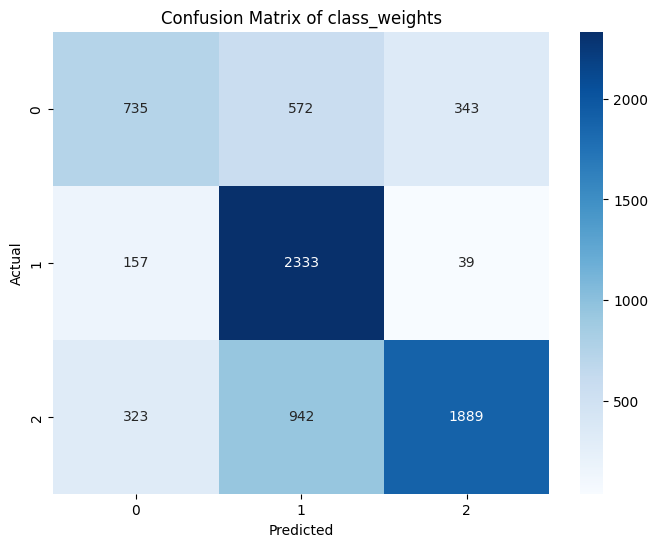

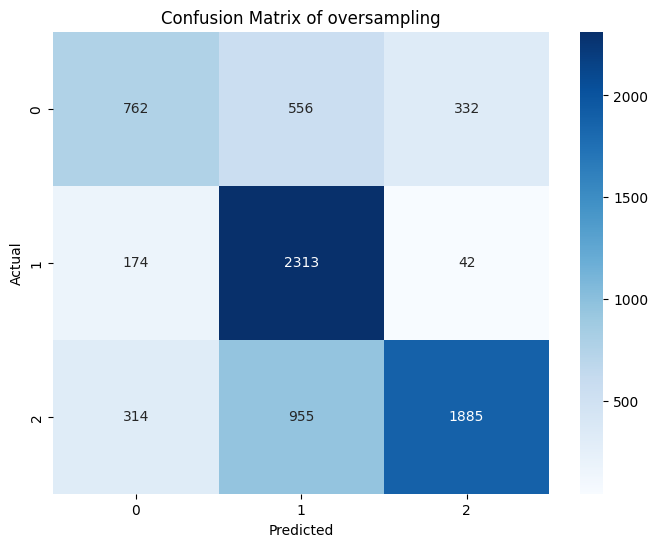

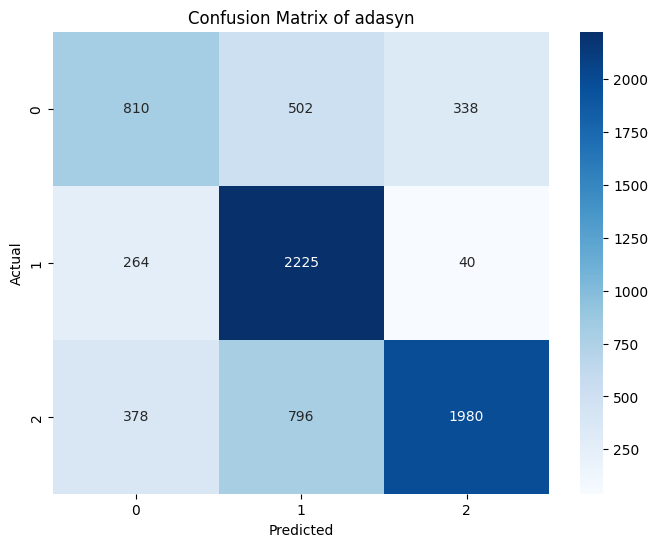

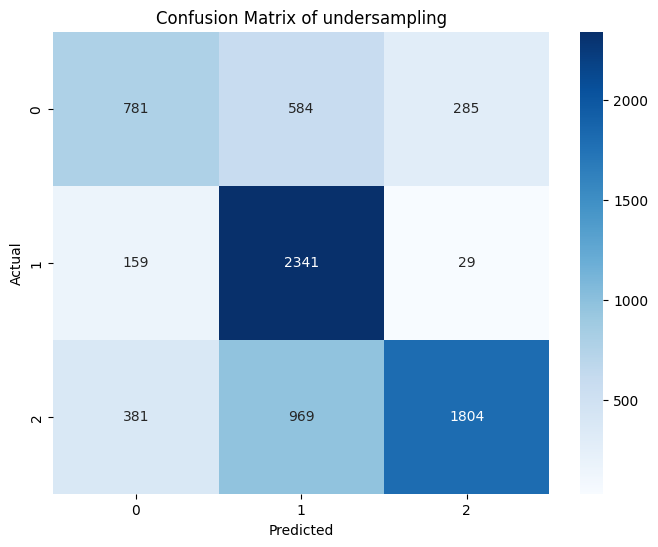

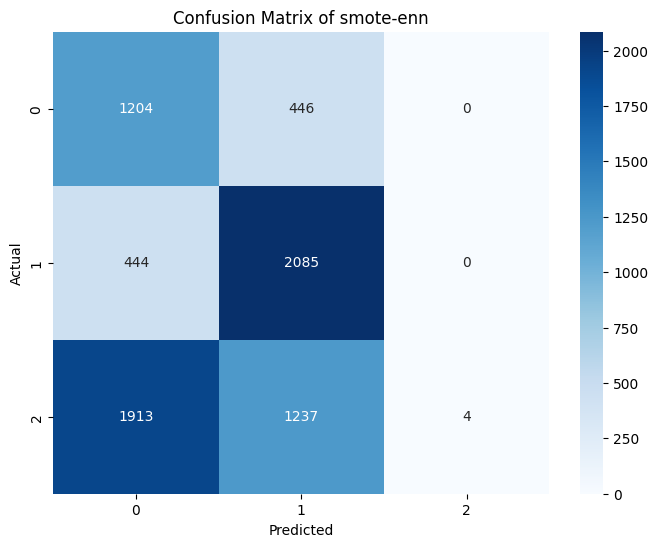

In [8]:
imbalanced_metods=['class_weights','oversampling','adasyn','undersampling','smote-enn']
for method in imbalanced_metods:
  run_imbalanced_experiment(method)